# About ingedients
Borrowing the concept from NLP, I tried to embed ingredients in recipe to see if we can observe any relationship. 
### Question: Can we observe a relationship amongst ingredient?
### Current conclusion: Not really
There are probably many reasons why. For one, not enough data. And second, the ingredients need to be lemmatized for a better result.

In [3]:
import pickle
import numpy as np
import pandas as pd
import pickle
import re
import string
import random
from collections import Counter
import tensorflow as tf
import time
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Task 1: Find closely related ingredients
## 1-1. Prepare dataset
I am using word embedding techniques using TensorFlow

In [4]:
with open("data/_nID_ingredients_dict.pkl", "rb") as fp:
    nID_ingredients_dict = pickle.load(fp)

In [5]:
# Each ingredient is already tokenized
words = []
for i in list(nID_ingredients_dict.keys()):
    ing = nID_ingredients_dict.get(i, -1)
    for ig in ing:
        words.append(ig)
    words.append(" ") # add to indicate End of sentence
    
len(words)

9937

In [60]:
print("Total words: {}".format(len(words)-1)) #Remove filler
print("Total unique words: {}".format(len(set(words))-1)) #Remove filler

Total words: 9936
Total unique words: 1390


In [63]:
# Count the words and order than into most frequent to least frequent
word_freq = Counter(words)

In [64]:
#Make it into pandas dataframe
word_freq_df = pd.DataFrame.from_dict(word_freq, orient = "index").reset_index(drop = False)
col_names = ["word", "count"]
word_freq_df.columns = col_names
#sort order
word_freq_df = word_freq_df.sort_values(by = "count", ascending = False)

In [68]:
word_freq_df[:10]

,word,count
870,,614
338,소금,415
198,양파,342
373,후추,336
1127,대파,274
173,달걀,260
1215,마늘,246
1040,설탕,238
494,밀가루,216
1159,간장,212


In [69]:
word_freq_df["int"] = pd.Series(list(np.arange(len(word_freq_df)))).values
word_freq_df[:10]

,word,count,int
870,,614,0
338,소금,415,1
198,양파,342,2
373,후추,336,3
1127,대파,274,4
173,달걀,260,5
1215,마늘,246,6
1040,설탕,238,7
494,밀가루,216,8
1159,간장,212,9


In [70]:
vocab_to_int = dict(zip(word_freq_df.word, word_freq_df.int))
int_to_vocab = dict(zip(word_freq_df.int, word_freq_df.word))

In [71]:
# Change words into int
int_words = [vocab_to_int[word] for word in words]

### Sub-sampling: Remove words that appear less-frequently

In [211]:
threshold = 1e-2
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
# train_words = int_words

In [212]:
len(train_words)

8314

In [203]:
len(words)

9937

Now the train dataset is ready

## 1-2. Make batches

In [213]:
def get_target(words, idx, window_size = 10):
    R = np.random.randint(1, window_size + 1)
    start = idx - R if (idx - R)>0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx + 1: stop + 1])
    
    return list(target_words)

In [214]:
def get_batches(words, batch_size, window_size):
    n_batches = len(words) // batch_size
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        
        ## Remove the batch with filler ########
        if len(set(batch).intersection(" ")) >0:
            pass
        ########################################
        else:
            for ii in range(len(batch)):
                batch_x = batch[ii]
                batch_y = get_target(batch, ii, window_size)
                y.extend(batch_y)
                x.extend([batch_x]*len(batch_y))
            yield x, y

In [215]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name = 'inputs')
    labels = tf.placeholder(tf.int32, [None, None], name = 'labels')

In [216]:
n_vocab = len(int_to_vocab)
n_embedding = 200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [217]:
# Number of negative labels to sample
n_sampled = 20
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev = 0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    loss = tf.nn.sampled_softmax_loss(softmax_w,
                                     softmax_b,
                                     embed,
                                     labels,
                                     n_sampled,
                                     n_vocab)
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## 1-3. Validation

In [218]:
with train_graph.as_default():
    valid_size = 10
    valid_window = 200
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                              random.sample(range(100,100+valid_window), valid_size//2))
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims = True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [219]:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [220]:
epochs = 10
batch_size = 20
window_size = 15

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 100 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 5 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    #save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)
    #embed_mat = sess.run(embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 4.5116 0.0050 sec/batch
Nearest to 파르메산 치즈: 조청, 크림소스, 건새우, 비지, 상추,
Nearest to 꿀: 무말랭이장아찌, 석류식초, 냉동 시금치, 아몬드 슬라이스, 선드라이토마토,
Nearest to 파프리카: 전분, 데친 관자, 바지락, 베트남고추, 핫소스,
Nearest to 슬라이스 치즈: 쌈장, 오븐구이용 삼치, 발사믹소스, 아몬드, 깍두기,
Nearest to 두부: 농어, 귤, 깍두기국물, 야채참치, 매운치킨소스,
Nearest to 두반장: 타코야키소스, 소고기등심, 황태채, 제비집, 갈릭소스,
Nearest to 장어: 안초비, 찬밥, 프라이드 치킨, 참깨&흑임자소스, 어포,
Nearest to 코코넛 밀크: 갈릭디핑소스, 두부피, 꼬리곰탕, 나초, 슬라이스치즈,
Nearest to 깻잎장아찌: 버터쿠키, 알배추, 생강즙, 소불고기양념, 고등어,
Nearest to 망고: 분홍소시지, 코코넛오일,  , 오미자 원액, 연겨자,
Epoch 1/10 Iteration: 200 Avg. Training loss: 4.3504 0.0054 sec/batch
Nearest to 파르메산 치즈: 조청, 크림소스, 건새우, 상추, 된장,
Nearest to 꿀: 무말랭이장아찌, 석류식초, 냉동 시금치, 아몬드 슬라이스, 선드라이토마토,
Nearest to 파프리카: 전분, 바지락, 데친 관자, 베트남고추, 핫소스,
Nearest to 슬라이스 치즈: 쌈장, 오븐구이용 삼치, 발사믹소스, 깍두기, 아몬드,
Nearest to 두부: 농어, 귤, 깍두기국물, 야채참치, 매운치킨소스,
Nearest to 두반장: 타코야키소스, 소고기등심, 제비집, 갈릭소스, 황태채,
Nearest to 장어: 안초비, 찬밥, 프라이드 치킨, 참깨&흑임자소스, 파파야,
Nearest to 코코넛 밀크: 갈릭디핑소스, 두부피, 꼬리곰탕, 나초, 슬라이스치즈,
Nea

In [201]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [221]:
viz_words = 200
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

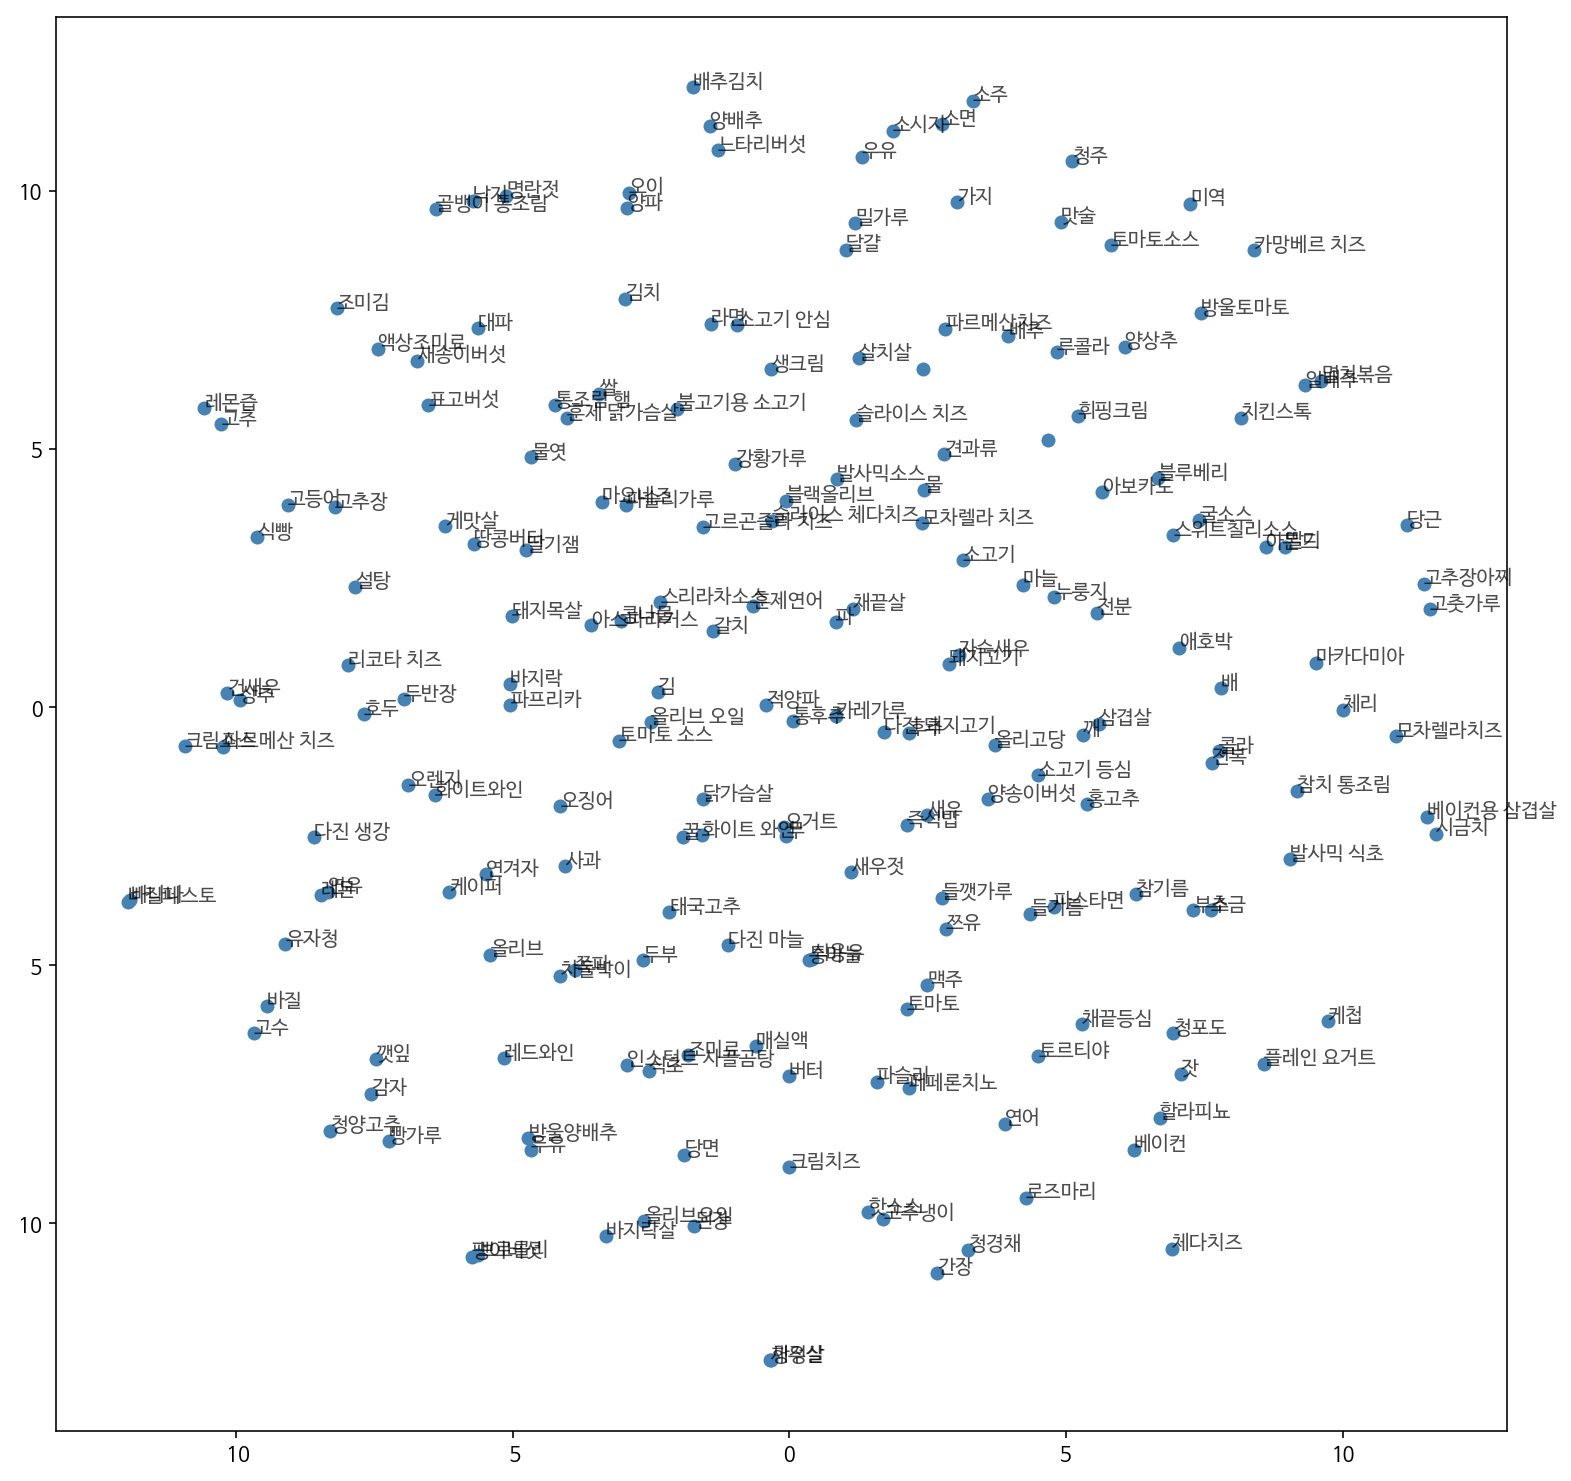

In [222]:
font_name = font_manager.FontProperties(fname = '/Users/db91057/Library/Fonts/custom/NanumBarunGothic.ttf').get_name()
rc('font', family = font_name)

fig, ax = plt.subplots(figsize=(13, 13))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

### Okay. Not so apparent.

As I have stated earlier, the dataset is way to small. Plus, there is the problem of lemmatization of ingredients. Nevertheless, it was a fun proof of concept.

# Task 2: Find similar recipe
* Remove most frequent ingredients
* Find matching scores

----------------------------------------------
## 2-1 Prepare dataset

In [7]:
with open("data/_nID_menu_names_dict.pkl", "rb") as fp:
    nID_menu_names_dict = pickle.load(fp)

In [254]:
new_nID_ingredients_dict = {}
new_ing = []
for i in list(nID_ingredients_dict.keys()):
    ing = nID_ingredients_dict.get(i, -1)
    new_nID_ingredients_dict[i] = [x for x in ing if x not in remove_list]
    for j in ing:
        if j not in remove_list:
            new_ing.append(j)

new_unique_ing = list(set(new_ing))

In [257]:
id_nID_dict = dict(zip(range(0,len(nID_ingredients_dict)),list(nID_ingredients_dict.keys())))
nID_id_dict = {k:v for v,k in id_nID_dict.items()}

In [266]:
ing_matrix = np.zeros([len(new_nID_ingredients_dict), len(new_nID_ingredients_dict)])

for key in list(new_nID_ingredients_dict.keys()):
    update_row = nID_id_dict.get(key)
    ingredients = new_nID_ingredients_dict.get(key, -1)
    
    # compare with others
    for key in list(new_nID_ingredients_dict.keys()):
        update_column = nID_id_dict.get(key)
        compare = new_nID_ingredients_dict.get(key,-1)
        match_cnt = len(set(ingredients).intersection(compare))
        
        # Update matrix
        ing_matrix[update_row,update_column] = match_cnt   

## 2-2. Look for similar recipe (meaning *similar* ingredients, not the cooking method) 

In [291]:
def find_similar_recipe(recipe_num, top_n):
    idnum = nID_id_dict[recipe_num]
    print("Looking for the recipe with similar ingredients: ", nID_menu_names_dict.get(recipe_num))
    print(new_nID_ingredients_dict.get(recipe_num))
    print("-----------------------------------------")
    idx = (-ing_matrix[idnum]).argsort()[:top_n+1]
    for idx, j in enumerate(idx[1:]):
        print("Top ", idx+1,":")
        nID = id_nID_dict.get(j)
        print(nID_menu_names_dict.get(nID))
        print(new_nID_ingredients_dict.get(nID))
        print(int(ing_matrix[idnum,j])," Matching ingredients")
        print("==========================================")

### What are other recipe (top 3) that has similar ingredients as recipe # 5996?

In [292]:
find_similar_recipe(5996,3)

Looking for the recipe with similar ingredients:  고기 차이나
['닭가슴살', '채끝살', '청경채', '파프리카', '굴소스', '양상추', '감자 전분', '밀가루', '식용유', '간장', '식초', '레몬즙', '다진 마늘']
-----------------------------------------
Top  1 :
새로 깐풍치킨
['프라이드 치킨', '굴소스', '밀가루', '다진 마늘', '간장', '식초', '레몬즙', '파', '청양고추']
6  Matching ingredients
Top  2 :
풍절판
['삼겹살', '새송이버섯', '팽이버섯', '브로콜리', '파프리카', '감자', '굴소스', '다진 마늘', '다진 생강', '밀가루', '맛술', '깨', '간장', '식초', '참기름']
6  Matching ingredients
Top  3 :
뚝닭뚝닭
['닭안심', '깻잎', '파프리카', '베트남고추', '굴소스', '고추', '다진 생강', '다진 마늘', '청주', '간장', '식초']
5  Matching ingredients


### Wow so many choices!
------------------------------------------

## 2-3. Let's get some more samples
### What are you cooking for dinner today? Anything look good here?

In [301]:
test_num = np.random.randint(0,len(new_nID_ingredients_dict), size = 3)
for i in test_num:
    find_similar_recipe(list(new_nID_ingredients_dict.keys())[i],3)
    print(" ")
    print(" ")

Looking for the recipe with similar ingredients:  파이널복스
['알배추', '차돌박이', '쪽파', '청양고춧가루', '소고기등심', '아스파라거스', '마늘종', '유자청', '아보카도', '우유', '굴소스', '간장', '전분', '청양고추', '맛술']
-----------------------------------------
Top  1 :
마무리고등어
['고등어', '우유', '표고버섯', '아보카도', '아스파라거스', '마늘종', '육포', '레몬', '다진 생강', '맛술', '간장', '청양고추', '당근', '버터', '올리브오일']
7  Matching ingredients
Top  2 :
벵에돔이시여
['긴꼬리벵에돔', '홍합', '무', '브로콜리', '아스파라거스', '쯔유', '그린올리브', '매실액', '깻잎', '청양고추', '고춧가루', '전분', '홍고추', '고추', '식초', '간장', '맛술']
5  Matching ingredients
Top  3 :
김흥국
['인스턴트 사골곰탕', '인스턴트 설렁탕', '찜갈비용 소고기', '대하', '알배추', '굴소스', '우동면', '청양고추', '간장', '청주', '굴소스', '전분']
5  Matching ingredients
 
 
Looking for the recipe with similar ingredients:  민들레 만들래
['민들레', '닭가슴살', '모차렐라 치즈', '애호박', '오이', '토마토', '레몬', '밀가루', '올리브오일']
-----------------------------------------
Top  1 :
가지에 빠져빠져♬
['가지', '애호박', '새송이버섯', '양배추', '훈제연어', '크림치즈', '후리카케', '토마토소스', '요거트', '밀가루', '즉석밥', '참기름', '식초', '올리브오일', '레몬']
4  Matching ingredients
Top  2 :
시금치~즈
['